# 1. Introduction

This project attempts to cluster and classify weather station in the UK based on weather data. 
The objective of the clustering exercise is to confirm whether running a clustering algorithm on weather data can be used to cluster stations that have “similar” weather?
The objective of the classification exercise is to attemt to predict whether stations fall in the Northern Third of the UK, Central Third of the UK or Southern Third of the UK using only weather data. 

Finally, the project attempts to run a very simple analysis to check whether the weather affects how happy people in the UK are. Given the data available, only a coarse-grained analysis is possible, due to the fact that places where there are weather stations do not correspond directly to the census areas used in the happiness surveys. 

This project works with two publicly available data sets:1. Historic weather/climate data from the UK: this can be obtained from https://www.metoffice.gov.uk/research/climate/maps-anddata/historic-station-data. Data is stored by weather station.2. Self-reported happiness statistics from the UK: this can be obtained from http://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/personalwellb eingestimatesgeographicalbreakdown. The dataset contains four sub-datasets (life satisfaction, worthwhile, happiness and anxiety), but only the "happiness" dataset is used. 

In [1]:
#import libraries

import csv
import requests
import os
import re
import pandas as pd
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore')

# 2. Importing Weather Data

## Weather data dataframe

### Compiling a single dataframe

Weather data from the Met Office is stored by station. To be able to analyse it efficiently, I wanted to load data from all stations into a single dataframe. In order to do that, I created a list with all the station names from thestations.txt that can be find in the same repository as this Notebook. I used the list to loop through the Met Office URL to fetch each station’s data. Using a lookup loop, I removed the first few lined of text from each file and concatenated each of them in a single dataframe, adding a column with the station name. 

In [2]:
#Create a list of all station names
#File is in Github repo

stations_list = open("stations.txt", "r").readlines()
stations = []

for i in range(len(stations_list)):
    stations.append(stations_list[i].strip('\n'))

In [3]:
#This code fetches files from the Metoffice website
#this block should be run when new data needs to be fetched

#filenames = []

#for station in stations:
    #url= "http://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/" + station + 'data.txt'
    #r = requests.get(url, allow_redirects=True)
    #open(station+'.txt', 'wb').write(r.content)
    #filenames.append(station+'.txt')

In [48]:
#this block should be run when the data is available and does not need to be refreshed
#data used in this specific case was added to github repo

filenames = []

for station in stations:
    file_name = station + '.txt'
    filenames.append(file_name)

#let's have a look at a couple of files to see how they are structured
with open("aberporth.txt", "r") as file:
    for _ in range(10):
        print(file.readline().strip())

with open("nairn.txt", "r") as file:
    for _ in range(10):
        print(file.readline().strip())

with open("whitby.txt", "r") as file:
    for _ in range(10):
        print(file.readline().strip())

Aberporth
Location: 224100E 252100N, Lat 52.139 Lon -4.570, 133 metres amsl
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.
yyyy  mm   tmax    tmin      af    rain     sun
degC    degC    days      mm   hours
1941   1    ---     ---    ---     74.7     ---
1941   2    ---     ---    ---     69.1     ---
1941   3    ---     ---    ---     76.2     ---
Nairn   there is a site change in 1998
Location before 1998 286900E 856800N 8m amsl
after 1998 291200E 857300N, Lat 57.593 Lon -3.821, 23 m amsl
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.
yyyy  mm   tmax    tmin      af    r

In [5]:
#this loop creates one dataframe with all weather data from all stations

stations_data = []

#Data files should have 7 feature columns, however running the code by giving only the 7 header titles gives an error, saying there are actually 10 features in some observations. 
#Therefore, to write a simpler loop, I will recode 4 different 'notes' fields and I will consolidate them later
col_names_tmp = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours', 'notes1','notes2','notes3','notes4']

for file in filenames:
    #All files contain a few description lines at the top (see above), which need to be removed. The compilation should start from the columns header, which starts with a year. 
    lookup = "yyyy"
    with open(file) as current:
        for num, line in enumerate(current, 1):
            if lookup in line:
                start_file = num
    df = pd.read_table(file, sep='\\s+', skiprows = start_file +1, names = col_names_tmp)
    #I want to add an extra column with the station name
    df['station'] = file.replace('.txt', '')
    #I will merge the 'notes' columns
    stations_data.append(df)
    
weather_data = pd.concat(stations_data, ignore_index=True)
#consolidate the notes column, being mindful of the NaNs
weather_data['notes'] = (weather_data['notes1'].fillna('') + weather_data['notes2'].fillna('') +
                         weather_data['notes3'].fillna('') + weather_data['notes4'].fillna(''))
weather_data = weather_data.drop(columns=['notes1', 'notes2', 'notes3', 'notes4'])

weather_data


,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,station,notes
0,1941,1,---,---,---,74.7,---,aberporth,
1,1941,2,---,---,---,69.1,---,aberporth,
2,1941,3,---,---,---,76.2,---,aberporth,
3,1941,4,---,---,---,33.7,---,aberporth,
4,1941,5,---,---,---,51.3,---,aberporth,
...,...,...,...,...,...,...,...,...,...
39261,2023,10,17.2,9.2,0,117.2,101.6#,yeovilton,Provisional
39262,2023,11,11.9,5.2,4,92.8,67.7#,yeovilton,Provisional
39263,2023,12,11.3,5.7,5,135.0,18.6#,yeovilton,Provisional
39264,2024,1,8.5,1.4,10,62.0,77.3#,yeovilton,Provisional


In [6]:
#these are lists of columns for convenience 

col_names = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours', 'station','notes']
col_numeric = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']
col_features = ['tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']


This is an explanation of all columns:
- Mean daily maximum temperature (tmax)
- Mean daily minimum temperature (tmin)
- Days of air frost (af)
- Total rainfall (rain)
- Total sunshine duration (sun)

### Cleaning the dataframe

To clean the dataset and recode each column with the right variable type, I identified and removed all
alphabetical characters and symbols from the columns that should only contain numeric characters. Some were
provided by the dataset creator in the headline of each file (e.g., estimated data marked with an asterisk), some
others were the result of the import process, which was designed to be efficient rather than overly
accurate. I also dropped a few lines of the dataframe that indicated the month a site was closed. This cleaning
process resulted in loss of some data, especially in the notes column. This was not needed for the purpose of the
exercise, but If I had had more time I probably would have attempted to save as much data as possible. After that, I recoded every column in an appropriate data type. Years (yyyy) and months (mm) as integers, notesand station as objects, and everything else as floats.

In [7]:
#check for all alphabetical chatacters in the columns that should only contain numbers, excluding NaN
weather_data[weather_data[col_numeric].apply(lambda row: row.astype(str).str.contains(r'[A-Za-z][^Nan]+$', case=False).any(), axis=1)]



,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,station,notes
9302,Site,closed,NaN,NaN,NaN,NaN,NaN,cwmystwyth,
18563,2007,9,18.5,11.2,0,34.1,152.0Change,lowestoft,toMoncktonAve
25195,Site,Closed,NaN,NaN,NaN,NaN,NaN,ringway,
30690,Site,Closed,NaN,NaN,NaN,NaN,NaN,southampton,
36940,2000,1,8.1,2.9,1,43.5,71.6all,whitby,datafromWhitby


In [8]:
import numpy as np

#remove asterisks and hash as per data description
#cleans the cells identified in the previous steps and drops the Site Closed rows

weather_data[col_numeric] = weather_data[col_numeric].replace('---', np.NaN, regex=True)
weather_data[col_names] = weather_data[col_names].replace(r'[|#^&+$-%*/=!>]+','', regex=True)
weather_data[col_features] = weather_data[col_features].replace(r'[^0-9.]+','', regex=True)
weather_data.drop(weather_data[weather_data['yyyy'] == 'Site'].index, inplace = True)


In [9]:
#repeat the check
weather_data[weather_data[col_numeric].apply(lambda row: row.astype(str).str.contains(r'[A-Za-z][^Nan]+$', case=False).any(), axis=1)]


,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,station,notes


In [10]:
# recode the right type of variables
data_types = {'yyyy':int,'mm':int,'tmax degC':float,'tmin degC':float, 'af days':float, 'rain mm':float, 'sun hours':float, 'station':object }
weather_data = weather_data.astype(data_types)
weather_data.dtypes



yyyy           int64
mm             int64
tmax degC    float64
tmin degC    float64
af days      float64
rain mm      float64
sun hours    float64
station       object
notes         object
dtype: object

### Analysing the data

To analyse the data, I generated descriptive statistics for the features variables: maximum and
minimum temperature (tmax degC and tmin degC), air frost days (af days), rainfall in millimetres (rain mm), and
hours of sunlight (sun hours).

In [11]:
weather_data[col_features].describe()

,tmax degC,tmin degC,af days,rain mm,sun hours
count,38335.000000,38361.000000,36936.000000,38390.000000,30195.000000
mean,12.789234,6.107982,3.469298,73.262693,118.572863
std,5.048626,3.868710,5.164989,48.536248,63.352388
min,0.100000,-4.600000,0.000000,0.000000,2.800000
25%,8.600000,2.800000,0.000000,39.200000,64.700000
50%,12.400000,5.600000,1.000000,62.800000,112.000000
75%,16.900000,9.500000,6.000000,95.500000,163.900000
max,28.300000,17.000000,31.000000,568.800000,350.300000


I also looked at the correlation between these variables. The table of correlations shows that maximum
and minimum temperature are positively correlated. A relatively strong positive correlation can also be observed
between maximum temperature and hours of sunlight, while a relatively strong negative correlation can be
observed between air frost days and both maximum and minimum temperature.

In [12]:
correlations = weather_data.loc[:,['tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']].corr()
correlations

,tmax degC,tmin degC,af days,rain mm,sun hours
tmax degC,1.000000,0.928467,-0.725669,-0.171206,0.751979
tmin degC,0.928467,1.000000,-0.721933,-0.071417,0.626065
af days,-0.725669,-0.721933,1.000000,-0.019632,-0.479437
rain mm,-0.171206,-0.071417,-0.019632,1.000000,-0.375265
sun hours,0.751979,0.626065,-0.479437,-0.375265,1.000000


## Stations locations dataframe

The analysis require using the location of each station expressed as latitude and longitude. This data is included in the first few lines of text in each station’s data file. To create this dataframe, Iclooped through each file to extract these numbers from the text. I then had to clean the dataframe (the value of the Whitby station had extra characters) and recode the variables to the right type.

In [13]:
locations = []
stations_locations = pd.DataFrame() 
lat = []
lon = []
    
for file in filenames:    
    with open(file) as current:
        for line in current:
            start = 'Lat '
            end = ' Lon '
            end2 = ','
            if start in line:
                start_index = line.find(start)+len(start)
                lat_row = line[start_index:line.find(end,start_index)]
                lat.append(lat_row)
                start2_index = line.find(end)+len(end)
                lon_row = line[start2_index:line.find(end2,start2_index)]
                lon.append(lon_row)


stations_locations['station'] = filenames
stations_locations['station'] = stations_locations['station'].replace('.txt', '',regex=True)
stations_locations['lon'] = lon
stations_locations['lat'] = lat
stations_locations



,station,lon,lat
0,aberporth,-4.570,52.139
1,armagh,-6.649,54.352
2,ballypatrick,-6.153,55.181
3,bradford,-1.772,53.813
4,braemar,-3.396,57.006
5,camborne,-5.327,50.218
6,cambridge,0.102,52.245
7,cardiff,-3.187,51.488
8,chivenor,-4.147,51.089
9,cwmystwyth,-3.802,52.358


In [14]:
stations_locations[['lat','lon']] = stations_locations[['lat','lon']].astype(str)
stations_locations[stations_locations['lat'].str.contains('[A-Za-z]', case=False, na=False)]
stations_locations[stations_locations['lon'].str.contains('[A-Za-z]', case=False, na=False)]


,station,lon,lat
34,whitby,-0.624 41m amsl,54.481


In [15]:
#clean the whitby value
stations_locations['lon'] = stations_locations['lon'].astype(str).str.replace(' \S+', '', regex=True)
stations_locations = stations_locations.astype({'station':object,'lat':float,'lon':float})
stations_locations.dtypes

station     object
lon        float64
lat        float64
dtype: object

# 3. Clustering weather stations

To cluster the stations into stations with similar weather, I decided to:
- Use K-Means clustering
- Use the average value of all data points in each weather station. This is probably a controversial choice, due to the fact that weather is complex data that is seasonal, and yearly averages are not truly representative of weather throughout the year. However, this choice would simplify handling of missing values. 
- Use feature scaling and combine the features into two dimensions using Principal Component Analysis. I thought this would be an appropriate choice given the fact that most of the features have relatively strong correlations.

In [16]:
import sklearn as sk
import sklearn.datasets as skd
import sklearn.cluster as skc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



## 3.1 Preparing the data

Our dataframe included a lot of missing values, which needed to be filled to perform K-means clustering, I filled them with yearly averages by station, which is appropriate in this case since we will be using yearly averages to perform K-Means. In order to combine all the features into two dimensions with Principal Component Analysis, I scaled the features using StandardScaler, I grouped the dataframe by station, and then applied PCA. The two components explained 88,5% of the variables’ variance, which component 1 explaining about 60% and component 2 explaining about 29%.

In [17]:
#fill missing values

weather_data_means = weather_data.set_index(['station'])

for column in col_features:
    means = weather_data.groupby(['station'])[column].mean()
    weather_data_means[column] = weather_data_means[column].fillna(means)

weather_data_means = weather_data_means.reset_index()
weather_data_means = weather_data_means.drop(columns = ['notes'])


In [18]:
#Scaling features
weather_data_means[col_features] = StandardScaler().fit_transform(weather_data_means[col_features])






For the clustering exercise, I will only consider the last 10 years of the dataset, since global climate has changed substantially in the past century.

In [19]:
#consider only recent years, group by station


years = [2021,2020,2019,2018,2017,2016,2015,2014,2013,2012]

weather_data_station = weather_data_means[weather_data_means['yyyy'].isin(years)]
weather_data_station = weather_data_means.groupby(['station']).mean().reset_index()
weather_data_station

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,1982.084168,6.489980,-0.061314,0.307263,-0.393874,0.055394,0.186024
1,armagh,1938.083739,6.495131,0.034988,-0.091425,-0.040305,-0.096981,-0.249339
2,ballypatrick,1992.332447,6.510638,-0.273289,-0.125525,-0.177703,0.752743,-0.203745
3,bradford,1965.583931,6.492826,-0.091659,-0.058515,0.049752,-0.011232,-0.242219
4,braemar,1991.084399,6.487212,-0.445648,-0.563929,1.025585,0.048124,-0.350487
5,camborne,2000.915751,6.510989,0.141839,0.607394,-0.543959,0.345882,0.280869
6,cambridge,1991.084399,6.487212,0.313685,0.066817,0.016494,-0.561743,0.123717
7,cardiff,2000.415771,6.510753,0.387174,0.271321,-0.109378,0.515683,0.097930
8,chivenor,1987.823961,6.487775,0.361607,0.476571,-0.349996,0.033367,0.366489
9,cwmystwyth,1984.957929,6.498382,-0.231868,-0.275292,0.324225,1.573847,-0.372998


In [20]:
#Principal component analysis

from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(weather_data_station[col_features])
print('Variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=weather_data_station[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


Variation explained by each component: [0.59806512 0.28719786]
Cumulative variance explained by components: 88.53%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.308611   0.254509  0.176541  0.821661   0.365638
PC_2   0.209418   0.519526  0.605939  0.492704   0.276257


## 3.2 Running K-Means clustering


To determine how many clusters to use in K-means clustering, I decided to use the Elbow Method. The method
requires plotting the squared distances of the data points for a range of possible k values, and then
choose the optimal number of clusters based on the “elbow” of the curve.

In [21]:
#Create sum of squared distances list

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(weather_data_station[col_features])
    Sum_of_squared_distances.append(km.inertia_)


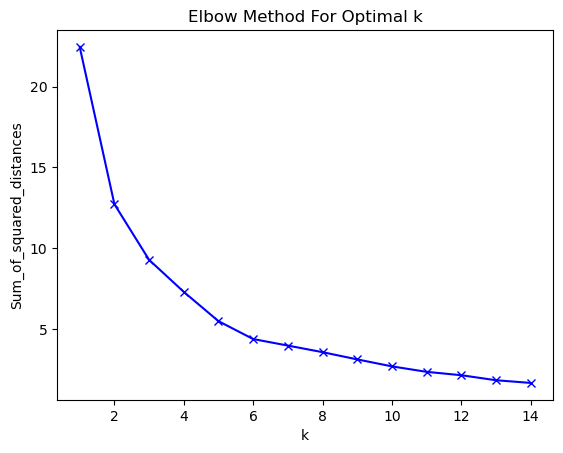

In [22]:
#Elbow method plot

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



There is no clear elbow in the graph – it could be anywhere between 3 and 6. The scatterplots below show the different options. The optimal seems to be 6, as the centroids of the clusters are more easily identifiable.



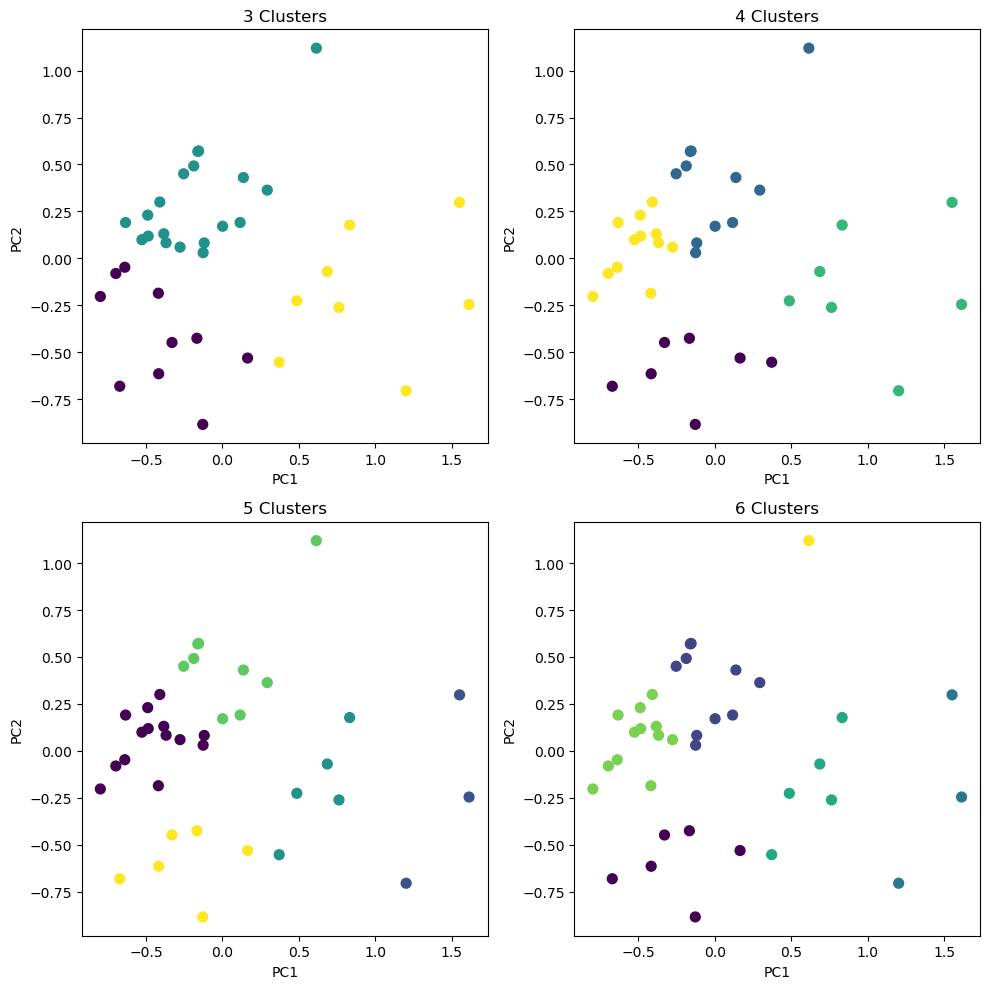

In [23]:
#run k means with different numbers of clusters and plot
model_clusters = [3, 4, 5, 6]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs_flat = axs.flatten()

scores = []  # Store scores
labels_dict = {}  # Store labels for each model

for i, n in enumerate(model_clusters):
    # Fit KMeans model
    model = skc.KMeans(n_clusters=n)
    model.fit(weather_data_station[col_features])
    
    # Calculate and save score
    score = model.score(weather_data_station[col_features])
    scores.append(score)
    
    # Save labels with the correct key
    labels_dict[f'labels{n}'] = model.labels_
    
    # Plot
    axs_flat[i].scatter(pca_2_result[:, 0], pca_2_result[:, 1], c=model.labels_, cmap='viridis', s=50)
    axs_flat[i].set_title(f'{n} Clusters')
    axs_flat[i].set_xlabel('PC1')
    axs_flat[i].set_ylabel('PC2')

plt.tight_layout()
plt.show()


In [24]:
#add labels to a data frame for visualization

scores_df = pd.DataFrame(scores, columns=['Score'], index=[f'Model{n}' for n in model_clusters])

labels_df = pd.DataFrame(labels_dict)
labeled_data = pd.concat([weather_data_station.reset_index(drop=True), labels_df], axis=1)



Let's look at the results visualized on the map. 

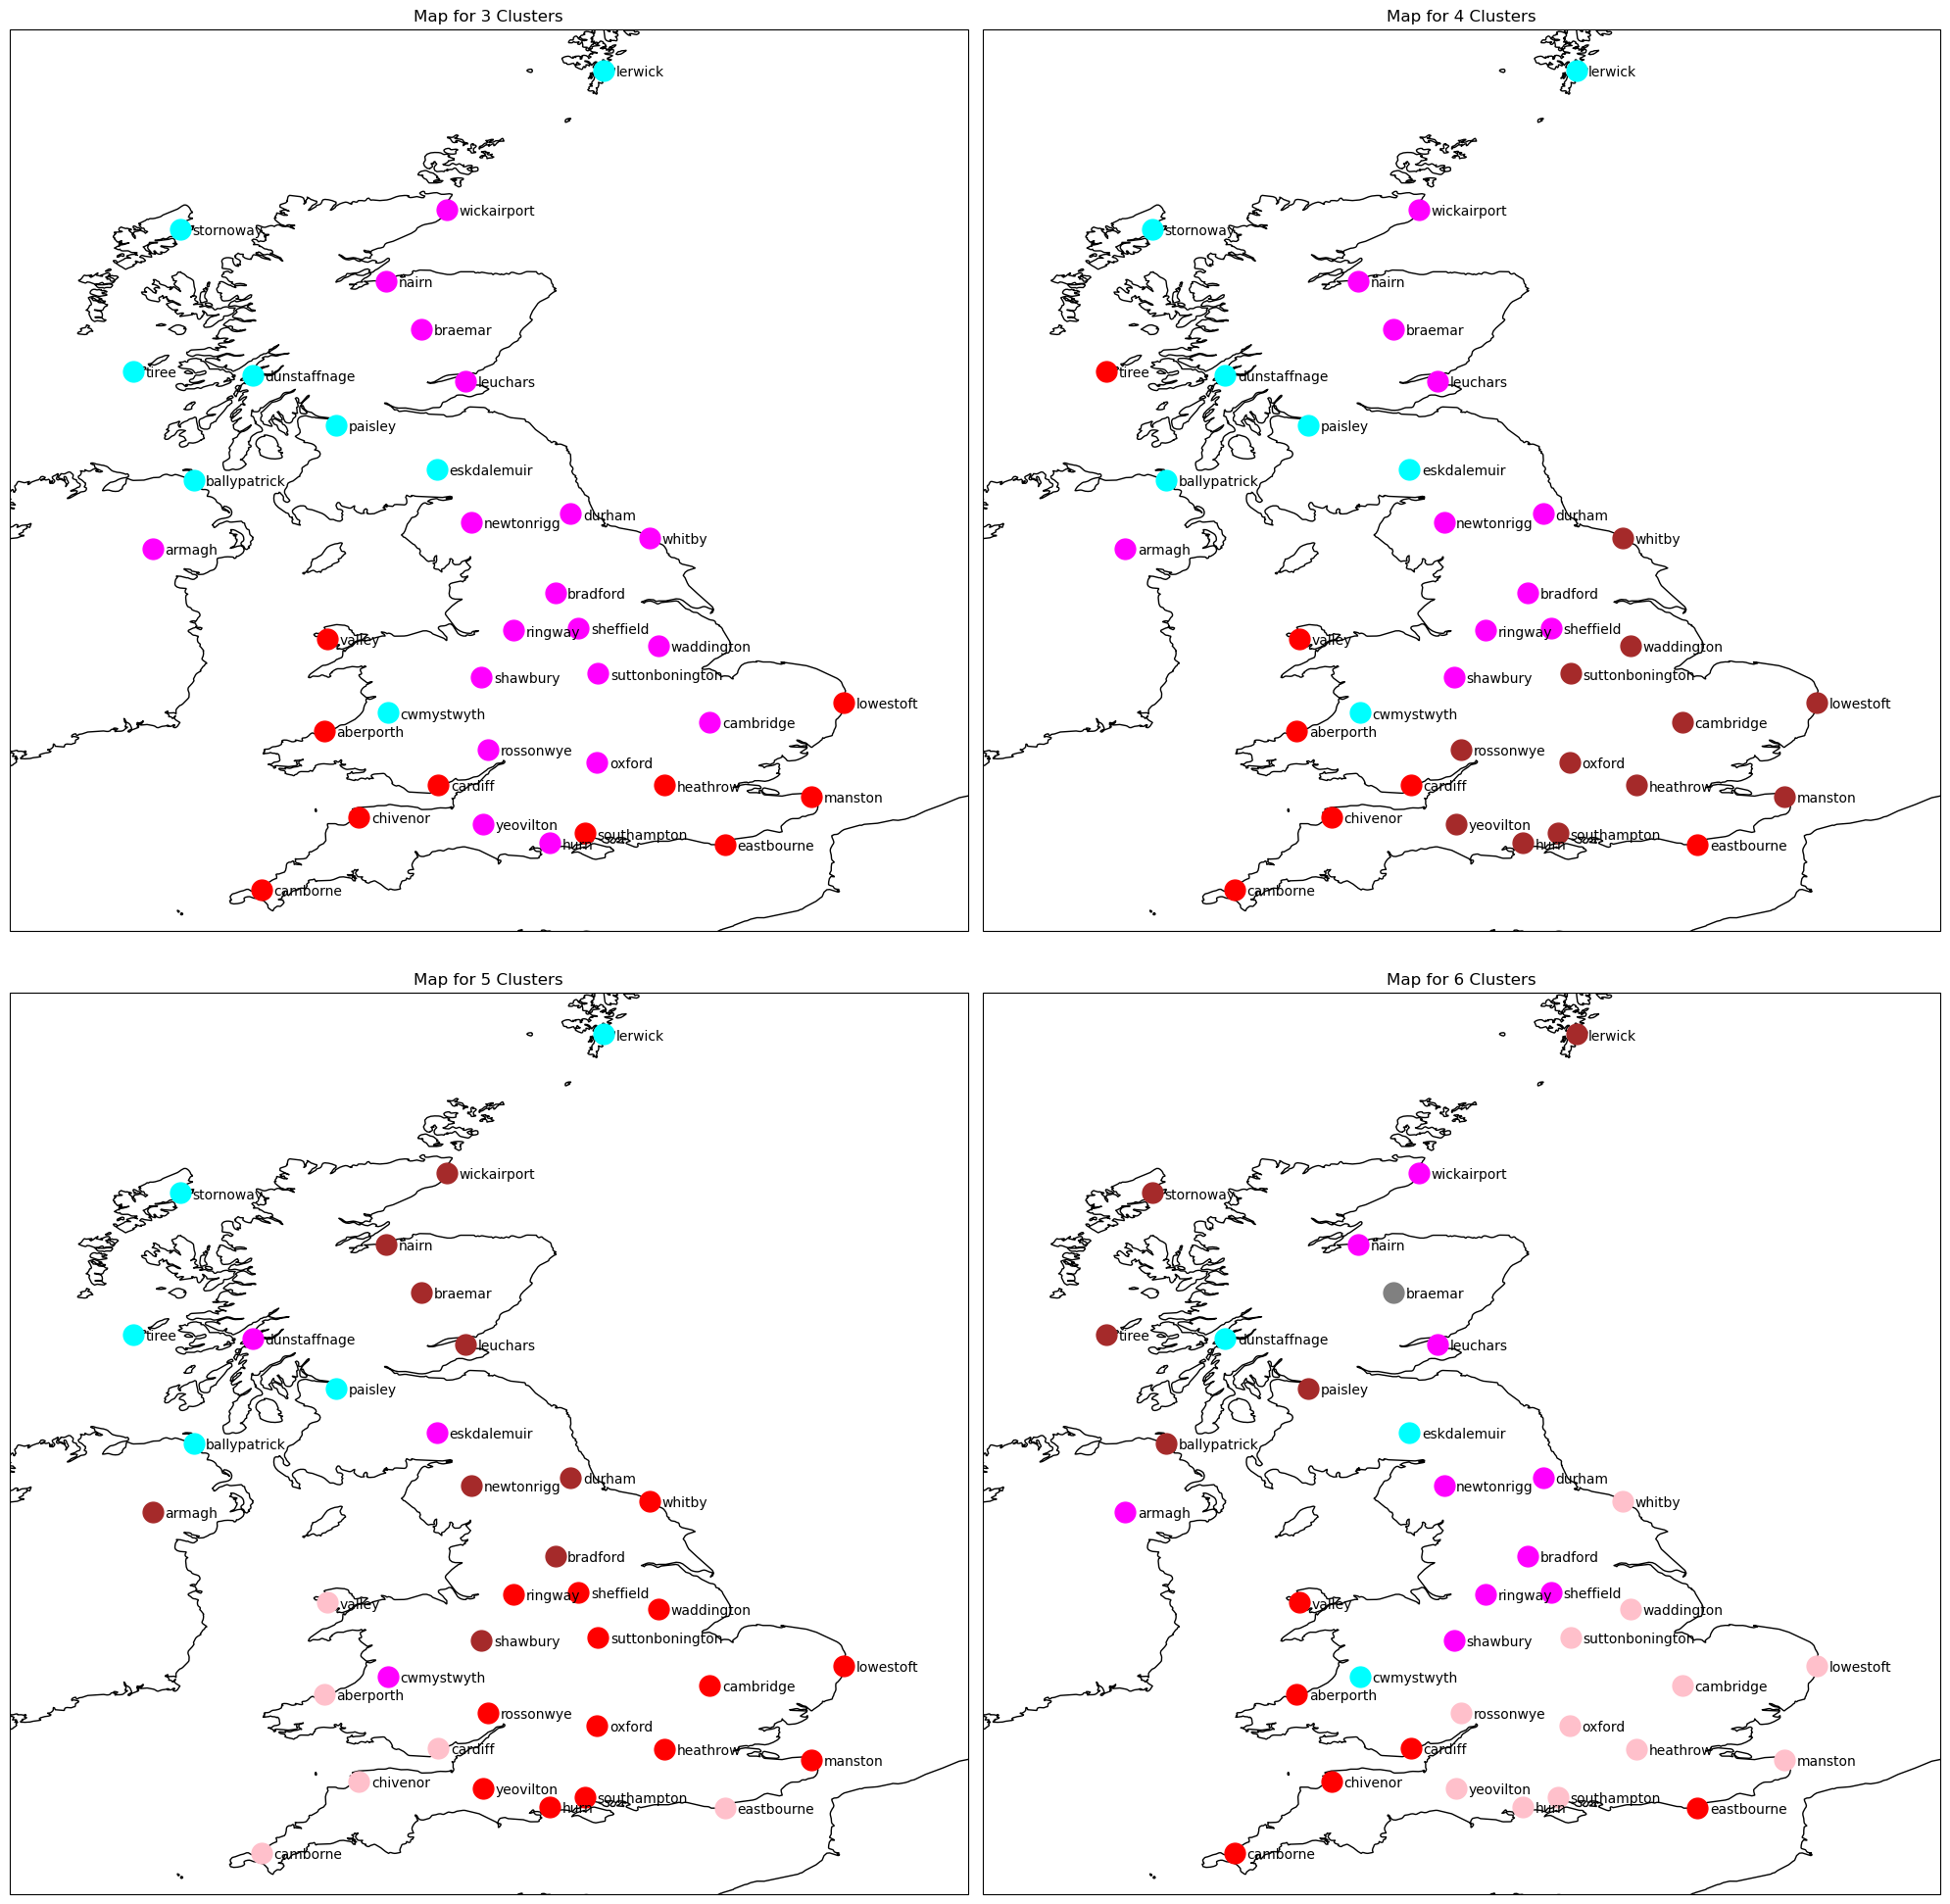

In [25]:
merged_data = stations_locations.merge(labeled_data, on='station', how='left')

color_map = {0: 'red',1: 'magenta',2: 'cyan', 3: 'brown', 4:'pink', 5: 'gray'}

import cartopy.crs as ccrs

min_lon, max_lon = merged_data['lon'].min(), merged_data['lon'].max()
min_lat, max_lat = merged_data['lat'].min(), merged_data['lat'].max()
buffer_lon = 1.5 
buffer_lat = 0.5  

# Define offsets for label positioning
horizontal_offset = 0.15
vertical_offset = 0.07

# Create a 2x2 subplot for the maps
fig, axs = plt.subplots(2, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()  # Flatten the array of axes for easier access

for i, n in enumerate([3, 4, 5, 6]):
    ax = axs[i]
    ax.set_extent([min_lon - buffer_lon, max_lon + buffer_lon, min_lat - buffer_lat, max_lat + buffer_lat], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    
    label_column = f'labels{n}'
    for _, row in merged_data.iterrows():
        color = color_map.get(row[label_column], 'black')
        ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=15, transform=ccrs.Geodetic())
        ax.text(row['lon'] + horizontal_offset, row['lat'] - vertical_offset, row['station'], 
                transform=ccrs.Geodetic(), fontsize=10, ha='left')
    
    ax.set_title(f'Map for {n} Clusters')

plt.tight_layout()
plt.show()

# 4. Classifying weather stations

To try to predict whether stations are in the North, Centre or South of the United Kingdom I will use a Naïve Bayes classifier, with a Gaussian algorithm since the data we are working with is continuous.

## 4.1 Preparing the data

To classify the Stations based on their locations, I started by generating descriptive statistics from the stations’ location dataframe.

In [26]:
stations_locations.describe()

,lon,lat
count,37.000000,37.000000
mean,-2.721378,53.781324
std,2.156905,2.522246
min,-6.880000,50.218000
25%,-4.147000,51.761000
50%,-2.663000,53.252000
75%,-1.262000,55.311000
max,1.727000,60.139000


I decided to determine a south upper-bound and a centre upper-bound by using the 0,33 and the 0,66 quantiles of the latitude variable. I also determined the middle bound of the country by using the 0,5 quantile of the longitude variable. I then proceeded to merge the stations’ locations dataframe and the weather data dataframe (grouped by station), to be able to run the classifier.

In [27]:
# define bounds
middle_bound = stations_locations['lon'].quantile(q=0.5)
south_bound = stations_locations['lat'].quantile(q=0.33)
center_bound = stations_locations['lat'].quantile(q=0.66)

#add lat_class to the labels
lat_class = []
for lat in stations_locations["lat"]:
    if lat >= center_bound:
        lat_class.append("North")
    elif lat < center_bound and lat >= south_bound:
        lat_class.append("Center")
    else:
        lat_class.append("South")
       
stations_locations["lat_class"] = lat_class   
stations_locations["lat_class"].value_counts()



lat_class
North     13
South     12
Center    12
Name: count, dtype: int64

In [28]:
#add lon_class to the labels
lon_class = []

for lon in stations_locations["lon"]:
    if lon >= middle_bound:
        lon_class.append("East")
    else:
        lon_class.append("West")

stations_locations["lon_class"] = lon_class   
stations_locations["lon_class"].value_counts()

lon_class
East    19
West    18
Name: count, dtype: int64

In [29]:
#group by station and merge the two dataframes

weather_data_station2 = weather_data.drop(columns = ['notes']).groupby(['station']).mean().reset_index()
weather_locations_station = pd.merge(stations_locations, weather_data_station2[['station','tmax degC','tmin degC','af days', 'rain mm','sun hours']], on = 'station', how = 'right')
weather_locations_station


,station,lon,lat,lat_class,lon_class,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,-4.570,52.139,South,West,12.494082,7.293509,1.497519,76.238377,128.488923
1,armagh,-6.649,54.352,Center,West,12.974830,5.767226,3.277923,68.893424,104.110568
2,ballypatrick,-6.153,55.181,North,West,11.435883,5.636681,2.586053,109.852844,106.663636
3,bradford,-1.772,53.813,Center,East,12.342599,5.893213,3.731408,73.026804,104.509267
4,braemar,-3.396,57.006,North,West,10.575450,3.958355,8.645244,75.887947,98.446739
5,camborne,-5.327,50.218,South,West,13.508242,8.442491,0.741758,90.240842,133.799814
6,cambridge,0.102,52.245,Center,East,14.366113,6.373018,3.563939,46.490369,125.000000
7,cardiff,-3.187,51.488,South,West,14.732975,7.155914,2.930108,98.425806,123.556054
8,chivenor,-4.147,51.089,South,West,14.605341,7.941667,1.718468,75.176598,138.594142
9,cwmystwyth,-3.802,52.358,Center,West,11.642660,5.063333,5.113523,149.432712,97.186254


### 4.2 Running the classifier

After defining datasets X and y as the relevant columns of my dataframe, I split the data set into training set and test set. The test set included 5 weather stations from the set. I then scaled the features again using StandardScaler, ran the classifier and predicted results for the test set. The accuracy score for the model was 0,6, and the confusion matrix is shown below.

In [30]:
# Importing the dataset
X = weather_locations_station.iloc[:, 5:].values
y = weather_locations_station.iloc[:, 3].values


In [31]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 5, random_state = 0)



In [32]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [33]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [34]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)



The accuracy score is 0.6


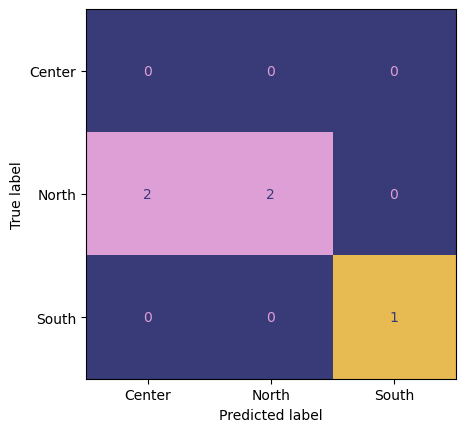

In [35]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
ac = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
print('The accuracy score is', ac)
cm_disp.plot(colorbar=False, cmap = 'tab20b')
plt.show()

# 5. Importing Happiness Data

## 5.1 Happiness data dataframe

The happiness data dataset was stored as an Excel file together with other datasets. I exported the dataset as a csv file and read the relevant columns in a dataframe. I decided to import only the Area Codes, Area names and Average happiness rating column (Avg rating). 

Due to the way the excel file was originally formatted, and since we only imported the first Area names column,the column includes a lot of missing values. For the purpose of the exercise, we will only use values that were included in the first Area names column, but in general it would be better to minimize data loss.

In [36]:
#import relevant columns from the csv
#File is in Github repo

happiness = pd.read_csv('happiness_data.csv', skiprows = 5,sep=';', nrows = 442, usecols =[0,1,8]) 
happiness.columns = ['Area Codes', 'Area names','Avg rating',]
happiness

,Area Codes,Area names,Avg rating
0,K02000001,UNITED KINGDOM,"7,46"
1,E92000001,ENGLAND,"7,45"
2,E12000001,NORTH EAST,"7,34"
3,E06000047,NORTH EAST,"7,37"
4,E06000005,NORTH EAST,"7,46"
...,...,...,...
437,N09000008,NaN,"8,03"
438,N09000009,NaN,"7,91"
439,N09000010,NaN,"7,84"
440,N09000011,NaN,"7,32"


## 5.2 Regions locations dataframe

The regions’ locations text file provided on learn can be read directly into a dataframe without manipulation.

In [37]:
#create a dataframe from the csv

regions = pd.read_csv('regions.txt', header = None) 
regions.columns = ['Area Codes', 'Area names', 'lat','lon']
regions

,Area Codes,Area names,lat,lon
0,E12000001,NORTH EAST,55.0,-1.9
1,E12000002,NORTH WEST,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
3,E12000004,EAST MIDLANDS,53.0,-0.8
4,E12000005,WEST MIDLANDS,52.5,-2.3
5,E12000006,EAST,52.2,0.4
6,E12000007,LONDON,51.5,-0.1
7,E12000008,SOUTH EAST,51.3,-0.5
8,E12000009,SOUTH WEST,51.0,-3.2
9,W92000004,WALES,51.5,-3.2


# 6. Weather and happiness

## 6.1 Preparing the data

### 6.1.1 Preparing the happiness data

To be able to join the happiness dataset and the weather dataset, I needed to apply the same latitude and longitude classification (North, Centre, South, East, West) I added to weather data to happiness data. To do that,first I filtered the Happiness data dataframe based on the list of Area codes in the Regions locations dataframe. At this point, I realised the Avg rating variable was still of type object, since decimals were separated by comma and not by dot. I replaced the commas and recoded the variable. Then, I merged the two dataframes based on the Area codes. Finally, I added the latitude and longitude classification using the same criteria and loop used before.

In [38]:
#filter the happiness data dataframe
area_codes = list(regions['Area Codes'])
happiness_filtered = happiness[happiness['Area Codes'].isin(area_codes)]

In [39]:
#replace commas with dots in avg rating
happiness_filtered['Avg rating'] = happiness_filtered['Avg rating'].apply(lambda x: x.replace(',', '.')).astype('float')

In [40]:
#merge happiness data and regions locations
regions_happiness = regions
regions_happiness = pd.merge(regions_happiness, happiness_filtered[['Area Codes','Avg rating']], on = 'Area Codes', how = 'right')

In [41]:
#add the latitude and longitude classification 
lat_class2 = []
for lat in regions_happiness["lat"]:
    if lat >= center_bound:
        lat_class2.append("North")
    elif lat < center_bound and lat >= south_bound:
        lat_class2.append("Center")
    else:
        lat_class2.append("South")
       
regions_happiness["lat_class"] = lat_class2   
regions_happiness["lat_class"].value_counts()

lon_class2 = []

for lon in regions_happiness["lon"]:
    if lon >= middle_bound:
        lon_class2.append("East")
    else:
        lon_class2.append("West")

regions_happiness["lon_class"] = lon_class2   
regions_happiness["lon_class"].value_counts()
regions_happiness["area"] = regions_happiness["lat_class"] + " " + regions_happiness["lon_class"]

regions_happiness

,Area Codes,Area names,lat,lon,Avg rating,lat_class,lon_class,area
0,E12000001,NORTH EAST,55.0,-1.9,7.34,North,East,North East
1,E12000002,NORTH WEST,54.0,-2.6,7.39,Center,East,Center East
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2,7.41,Center,East,Center East
3,E12000004,EAST MIDLANDS,53.0,-0.8,7.51,Center,East,Center East
4,E12000005,WEST MIDLANDS,52.5,-2.3,7.43,Center,East,Center East
5,E12000006,EAST,52.2,0.4,7.51,South,East,South East
6,E12000007,LONDON,51.5,-0.1,7.38,South,East,South East
7,E12000008,SOUTH EAST,51.3,-0.5,7.54,South,East,South East
8,E12000009,SOUTH WEST,51.0,-3.2,7.50,South,West,South West
9,W92000004,WALES,51.5,-3.2,7.44,South,West,South West


Before proceeding to prepare the weather data, I investigated descriptive statistics of the average happiness rating.

In [42]:
#descriptives of avg rating
regions_happiness['Avg rating'].describe()

count    12.000000
mean      7.470833
std       0.106725
min       7.340000
25%       7.405000
50%       7.445000
75%       7.510000
max       7.750000
Name: Avg rating, dtype: float64

### 6.1.2 Preparing weather data

Since the weather data dataframe was already grouped by station, I proceeded to group the dataframe by area (South West, South East, Centre West, Centre East, North West, North East). Lastly, I merged the happiness data dataframe and the weather data dataframe on the area variable.

In [43]:
weather_locations_station.dtypes

station       object
lon          float64
lat          float64
lat_class     object
lon_class     object
tmax degC    float64
tmin degC    float64
af days      float64
rain mm      float64
sun hours    float64
dtype: object

In [44]:
#group the weather data by latand lon and create an area column
weather_area = weather_locations_station.groupby(['lat_class', 'lon_class'])[col_features].mean().reset_index()

weather_area['area'] = weather_area["lat_class"] + " " + weather_area["lon_class"]
weather_area

,lat_class,lon_class,tmax degC,tmin degC,af days,rain mm,sun hours,area
0,Center,East,13.220135,6.194188,3.486656,57.041804,120.202433,Center East
1,Center,West,12.556857,6.129192,3.321724,96.554270,111.450193,Center West
2,North,East,10.970281,5.096820,3.934631,75.799104,100.273633,North East
3,North,West,11.636427,5.380313,4.160361,92.374359,106.763500,North West
4,South,East,14.311115,6.851930,3.307464,59.975865,135.971275,South East
5,South,West,13.835160,7.708395,1.721963,85.020406,131.109733,South West


In [45]:
#merge weather and happiness by region on area
happiness_weather = pd.merge(regions_happiness, weather_area[['area','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']], on = 'area', how = 'left')
happiness_weather

,Area Codes,Area names,lat,lon,Avg rating,lat_class,lon_class,area,tmax degC,tmin degC,af days,rain mm,sun hours
0,E12000001,NORTH EAST,55.0,-1.9,7.34,North,East,North East,10.970281,5.096820,3.934631,75.799104,100.273633
1,E12000002,NORTH WEST,54.0,-2.6,7.39,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2,7.41,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
3,E12000004,EAST MIDLANDS,53.0,-0.8,7.51,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
4,E12000005,WEST MIDLANDS,52.5,-2.3,7.43,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
5,E12000006,EAST,52.2,0.4,7.51,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
6,E12000007,LONDON,51.5,-0.1,7.38,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
7,E12000008,SOUTH EAST,51.3,-0.5,7.54,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
8,E12000009,SOUTH WEST,51.0,-3.2,7.50,South,West,South West,13.835160,7.708395,1.721963,85.020406,131.109733
9,W92000004,WALES,51.5,-3.2,7.44,South,West,South West,13.835160,7.708395,1.721963,85.020406,131.109733


## 6.2 Looking at correlations

The correlations table (Figure 16) between the Average happiness rating and the weather variables does not show any strong positive or negative correlation with any of the variables.

In [46]:
correlations = happiness_weather.loc[:,['Avg rating','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']].corr()
correlations_styled = correlations.style.apply(lambda x: ['background-color: yellow' if x.name == 'Avg rating' else '' for i in x], axis=1)
correlations_styled

,Avg rating,tmax degC,tmin degC,af days,rain mm,sun hours
Avg rating,1.000000,0.283363,0.181602,-0.082272,-0.200503,0.232928
tmax degC,0.283363,1.000000,0.836936,-0.541879,-0.393149,0.983130
tmin degC,0.181602,0.836936,1.000000,-0.906484,0.089325,0.872271
af days,-0.082272,-0.541879,-0.906484,1.000000,-0.346923,-0.588795
rain mm,-0.200503,-0.393149,0.089325,-0.346923,1.000000,-0.264932
sun hours,0.232928,0.983130,0.872271,-0.588795,-0.264932,1.000000


The trendline on the scatterplot shows a somewhat positive correlation.  However, it is worth noting that the results are based on yearly averages of weather data, which are not very representative of actual weather, and also on average, aggregate ratings of self-reported happiness.

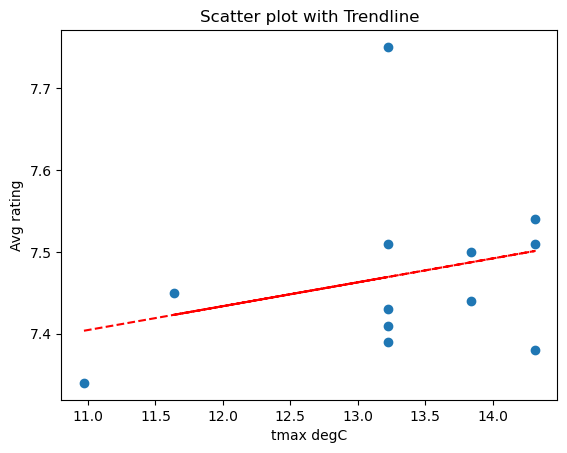

In [47]:
#plot the most correlated variable
x = happiness_weather['tmax degC']
y = happiness_weather['Avg rating']

plt.scatter(x, y)

# Calculate the trendline
z = np.polyfit(x, y, 1)  
p = np.poly1d(z) 

# Plot the trendline over the scatter plot
plt.plot(x, p(x), "r--") 

plt.xlabel('tmax degC')
plt.ylabel('Avg rating')
plt.title('Scatter plot with Trendline')

plt.show()